# The Mesh: Where do things live?

<img src="images/FiniteVolume.png" width=70% align="center">
<h4 align="center">Figure 3. Anatomy of a finite volume cell.</h4>

To bring our continuous equations into the computer, we need to discretize the earth and represent it using a finite(!) set of numbers. In this tutorial we will explain the discretization in 2D and generalize to 3D in the notebooks. A 2D (or 3D!) mesh is used to divide up space, and we can represent functions (fields, parameters, etc.) on this mesh at a few discrete places: the nodes, edges, faces, or cell centers. For consistency between 2D and 3D we refer to faces having area and cells having volume, regardless of their dimensionality. Nodes and cell centers naturally hold scalar quantities while edges and faces have implied directionality and therefore naturally describe vectors. The conductivity, $\sigma$, changes as a function of space, and is likely to have discontinuities (e.g. if we cross a geologic boundary). As such, we will represent the conductivity as a constant over each cell, and discretize it at the center of the cell. The electrical current density, $\vec{j}$, will be continuous across conductivity interfaces, and therefore, we will represent it on the faces of each cell. Remember that $\vec{j}$ is a vector; the direction of it is implied by the mesh definition (i.e. in $x$, $y$ or $z$), so we can store the array $\bf{j}$ as *scalars* that live on the face and inherit the face's normal. When $\vec{j}$ is defined on the faces of a cell the potential, $\vec{\phi}$, will be put on the cell centers (since $\vec{j}$ is related to $\phi$ through spatial derivatives, it allows us to approximate centered derivatives leading to a staggered, second-order discretization). 

# Implementation

In [1]:
%matplotlib inline
import numpy as np
from SimPEG import Mesh, Utils  
import matplotlib.pyplot as plt

plt.set_cmap(plt.get_cmap('viridis')) # use a nice colormap!

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Create a Mesh

A mesh is used to divide up space, here we will use [SimPEG's mesh class](http://docs.simpeg.xyz/content/api_core/api_Mesh.html) to define a simple tensor mesh. By "Tensor Mesh" we mean that the mesh can be completely defined by the tensor products of vectors in each dimension; for a 2D mesh, we require one vector describing the cell widths in the x-direction and another describing the cell widths in the y-direction. 

Here, we define and plot a simple 2D mesh using SimPEG's mesh class. The cell centers boundaries are shown in blue, cell centers as red dots and cell faces as green arrows (pointing in the positive x, y - directions). Cell nodes are plotted as blue squares. 

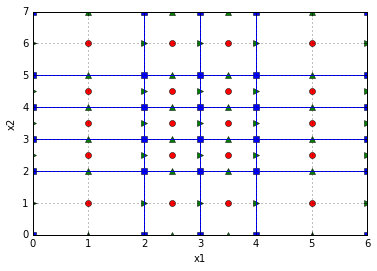

In [62]:
# Plot a simple tensor mesh
hx = np.r_[2., 1., 1., 2.]  # cell widths in the x-direction
hy = np.r_[2., 1., 1., 1., 2.]  # cell widths in the y-direction 
mesh2D = Mesh.TensorMesh([hx,hy])  # construct a simple SimPEG mesh
mesh2D.plotGrid(nodes=True, faces=True, centers=True)  # plot it!

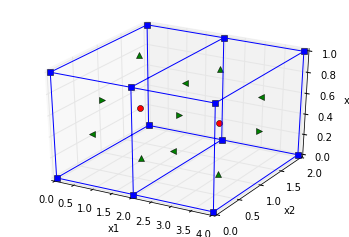

In [16]:
# This can similarly be extended to 3D (this is a simple 2-cell mesh)
hx = np.r_[2.,  2.]  # cell widths in the x-direction
hy = np.r_[2.]  # cell widths in the y-direction 
hz = np.r_[1.]  # cell widths in the z-direction 
mesh3D = Mesh.TensorMesh([hx,hy,hz])  # construct a simple SimPEG mesh
mesh3D.plotGrid(nodes=True, faces=True, centers=True)  # plot it!

## Counting things on the Mesh

Once we have defined the vectors necessary for construsting the mesh, it is there are a number of properties that are often useful, including keeping track of the
- number of cells: **`mesh.nC`**
- number of cells in each dimension: **`mesh.vnC`**
- number of faces: **`mesh.nF`**
- number of x-faces: **`mesh.nFx`** (and in each dimension **`mesh.vnFx`** ...)
and the list goes on. Check out [SimPEG's mesh documentation](http://docs.simpeg.xyz/content/api_core/api_FiniteVolume.html) for more. 

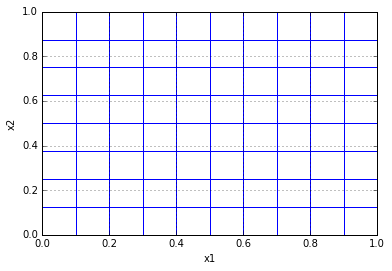

In [55]:
# Construct a simple 2D, uniform mesh on a unit square
mesh = Mesh.TensorMesh([10, 8])
mesh.plotGrid()

In [56]:
"The mesh has {nC} cells and {nF} faces".format(nC=mesh.nC, nF=mesh.nF)

'The mesh has 80 cells and 178 faces'

In [57]:
# Sometimes you need properties in each dimension
("In the x dimension we have {vnCx} cells. This is because our mesh is {vnCx} x {vnCy}.").format(
    vnCx=mesh.vnC[0],
    vnCy=mesh.vnC[1]
)

'In the x dimension we have 10 cells. This is because our mesh is 10 x 8.'

In [58]:
# Similarly, we need to keep track of the faces, we have face grids in both the x, and y 
# directions. 

("Faces are vectors so the number of faces pointing in the x direction is {nFx} = {vnFx0} x {vnFx1} "
"In the y direction we have {nFy} = {vnFy0} x {vnFy1} faces").format(
    nFx=mesh.nFx,
    vnFx0=mesh.vnFx[0],
    vnFx1=mesh.vnFx[1],
    nFy=mesh.nFy,
    vnFy0=mesh.vnFy[0],
    vnFy1=mesh.vnFy[1]  
)

'Faces are vectors so the number of faces pointing in the x direction is 88 = 11 x 8 In the y direction we have 90 = 10 x 9 faces'

## Simple properties of the mesh

There are a few things that we will need to know about the mesh and each of it's cells, including the  
- cell volume: **`mesh.vol`**,
- face area: **`mesh.area`**.

For consistency between 2D and 3D we refer to faces having area and cells having volume, regardless of their dimensionality.

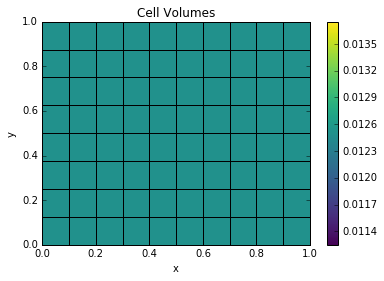

In [86]:
# On a uniform mesh, not suprisingly, the cell volumes are all the same
plt.colorbar(mesh.plotImage(mesh.vol, grid=True)[0])
plt.title('Cell Volumes');

In [98]:
# All cell volumes are defined by the product of the cell widths 

assert (np.all(mesh.vol == 1./mesh.vnC[0] * 1./mesh.vnC[1]))  # all cells have the same volume on a uniform, unit cell mesh

print ("The cell volume is the product of the cell widths in the x and y dimensions: "
       "{hx} x {hy} = {vol} ").format(
            hx = 1./mesh.vnC[0], # we are using a uniform, unit square mesh
            hy = 1./mesh.vnC[1],
            vol = mesh.vol[0]
       )

The cell volume is the product of the cell widths in the x and y dimensions: 0.1 x 0.125 = 0.0125 


The area of the x-faces is 0.125 and the area of the y-faces is 0.1


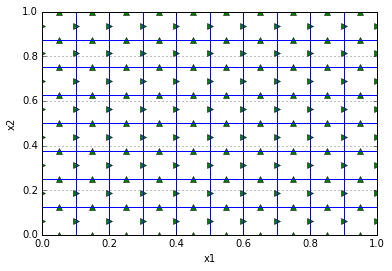

In [102]:
# Similarly, all x-faces should have the same area, equal to that of the length in the y-direction
assert np.all(mesh.area[:mesh.nFx] == 1.0/mesh.nCy)  # because our domain is a unit square

# and all y-faces have an "area" equal to the length in the x-dimension
assert np.all(mesh.area[mesh.nFx:] == 1.0/mesh.nCx)

print ("The area of the x-faces is {xFaceArea} and the area of the y-faces is {yFaceArea}").format(
        xFaceArea=mesh.area[0],
        yFaceArea=mesh.area[mesh.nFx]
      )

mesh.plotGrid(faces=True)

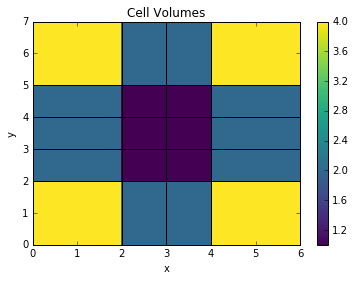

In [103]:
# On a non-uniform tensor mesh, the first mesh we defined, the cell volumes vary

# hx = np.r_[2., 1., 1., 2.]  # cell widths in the x-direction
# hy = np.r_[2., 1., 1., 1., 2.]  # cell widths in the y-direction 
# mesh2D = Mesh.TensorMesh([hx,hy])  # construct a simple SimPEG mesh

plt.colorbar(mesh2D.plotImage(mesh2D.vol, grid=True)[0])
plt.title('Cell Volumes');

## Grids and Putting things on a mesh

When storing and working with features of the mesh such as cell volumes, face areas, in a linear algebra sense, it is useful to think of them as vectors... so the way we unwrap is super important. 

Most importantly we want some compatibility with <a href="https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Compatibility_with_Kronecker_products">**Kronecker products**</a> as we will see later! This actually leads to us thinking about unwrapping our vectors column first. This column major ordering is inspired by linear algebra conventions which are the standard in Matlab, Fortran, Julia, but sadly not Python. To make your life a bit easier, you can use our MakeVector `mkvc` function from Utils.
 

In [131]:
from SimPEG.Utils import mkvc

In [149]:
mesh = Mesh.TensorMesh([3,4])

vec = np.arange(mesh.nC)

row_major = vec.reshape(mesh.vnC, order='C')
print('Row major ordering (standard python)')
print(row_major)

col_major = vec.reshape(mesh.vnC, order='F')
print('\nColumn major ordering (what we want!)')
print(col_major)

# mkvc unwraps using column major ordering, so we expect 
assert np.all(mkvc(col_major) == vec)

print('\nWe get back the expected vector using mkvc: {vec}'.format(vec=mkvc(col_major)))

Row major ordering (standard python)
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

Column major ordering (what we want!)
[[ 0  3  6  9]
 [ 1  4  7 10]
 [ 2  5  8 11]]

We get back the expected vector using mkvc: [ 0  1  2  3  4  5  6  7  8  9 10 11]


### Grids on the Mesh

When defining where things are located, we need the spatial locations of where we are discretizing different aspects of the mesh. A SimPEG Mesh has several grids. In particular, here it is handy to look at the 
- Cell centered grid: **`mesh.gridCC`**
- x-Face grid: **`mesh.gridFx`**
- y-Face grid: **`mesh.gridFy`**

In [134]:
# gridCC
"The cell centered grid is {gridCCshape0} x {gridCCshape1} since we have {nC} cells in the mesh and it is {dim} dimensions".format(
    gridCCshape0=mesh.gridCC.shape[0],
    gridCCshape1=mesh.gridCC.shape[1],
    nC=mesh.nC,
    dim=mesh.dim
)

'The cell centered grid is 12 x 2 since we have 12 cells in the mesh and it is 2 dimensions'

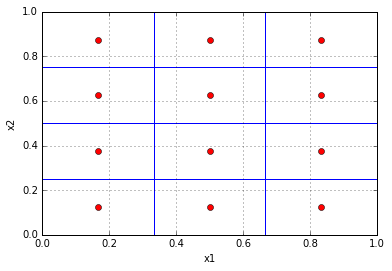

In [135]:
# The first column is the x-locations, and the second the y-locations

mesh.plotGrid()
plt.plot(mesh.gridCC[:,0], mesh.gridCC[:,1],'ro')

In [138]:
# gridFx
"Similarly, the x-Face grid is {gridFxshape0} x {gridFxshape1} since we have {nFx} x-faces in the mesh and it is {dim} dimensions".format(
    gridFxshape0=mesh.gridFx.shape[0],
    gridFxshape1=mesh.gridFx.shape[1],
    nFx=mesh.nFx,
    dim=mesh.dim
)

'Similarly, the x-Face grid is 16 x 2 since we have 16 x-faces in the mesh and it is 2 dimensions'

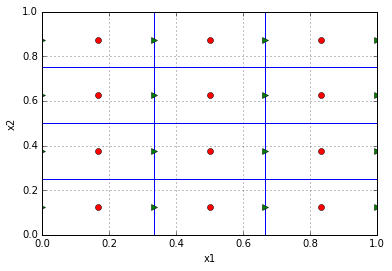

In [139]:
mesh.plotGrid()
plt.plot(mesh.gridCC[:,0], mesh.gridCC[:,1],'ro')
plt.plot(mesh.gridFx[:,0], mesh.gridFx[:,1],'g>')

## Putting a Model on a Mesh

In [index.ipynb](index.ipynb), we constructed a model of a block in a whole-space, here we revisit it having defined the elements of the mesh we are using. 

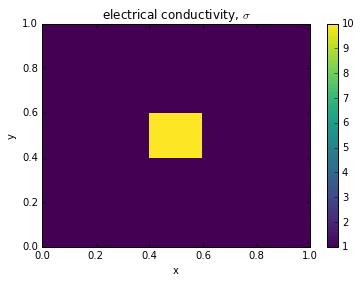

In [150]:
mesh = Mesh.TensorMesh([100, 80])  # setup a mesh on which to solve

# model parameters
sigma_background = 1.  # Conductivity of the background, S/m
sigma_block = 10.  # Conductivity of the block, S/m

# add a block to our model
x_block = np.r_[0.4, 0.6]
y_block = np.r_[0.4, 0.6]

# assign them on the mesh
sigma = sigma_background * np.ones(mesh.nC)  # create a physical property model 

block_indices = ((mesh.gridCC[:,0] >= x_block[0]) & # left boundary 
                 (mesh.gridCC[:,0] <= x_block[1]) & # right boudary
                 (mesh.gridCC[:,1] >= y_block[0]) & # bottom boundary
                 (mesh.gridCC[:,1] <= y_block[1]))  # top boundary

# add the block to the physical property model
sigma[block_indices] = sigma_block

# plot it!
plt.colorbar(mesh.plotImage(sigma)[0])
plt.title('electrical conductivity, $\sigma$')

## Next up ...
In the [next notebook](divergence.ipynb), we will work through defining the discrete divergence. 